## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import time
from sklearn.linear_model import LinearRegression

## Loading Dataset

In [2]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
alldat = np.array([])
for j in range(len(fname)):
    dat = np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat'])) 

## Selecting a session

In [3]:
ses = 0 #int(input())

In [4]:
dat = alldat[ses]

In [5]:
dat.keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

## Dataset overview

#### alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. 
Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

    dat['mouse_name']: mouse name
    dat['date_exp']: when a session was performed
    dat['spks']: neurons by trials by time bins.
    dat['brain_area']: brain area for each neuron recorded.
    dat['ccf']: Allen Institute brain atlas coordinates for each neuron.
    dat['ccf_axes']: axes names for the Allen CCF.
    dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
    dat['contrast_left']: contrast level for left stimulus.
    dat['gocue']: when the go cue sound was played.
    dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
    dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.
    dat['feedback_time']: when feedback was provided.
    dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).
    dat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.
    dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.
    dat['face']: average face motion energy from a video camera.
    dat['licks']: lick detections, 0 or 1.
    dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".
    dat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
    dat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
    dat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected).

In [6]:
def view():
    print("dat['mouse_name']: mouse name\ndat['date_exp']: when a session was performed\ndat['spks']: neurons by trials by time bins.\ndat['brain_area']: brain area for each neuron recorded.\ndat['ccf']: Allen Institute brain atlas coordinates for each neuron.\ndat['ccf_axes']: axes names for the Allen CCF.\ndat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.\ndat['contrast_left']: contrast level for left stimulus.\ndat['gocue']: when the go cue sound was played.\ndat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.n\dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.\ndat['feedback_time']: when feedback was provided.\ndat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).\ndat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.\ndat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.\ndat['face']: average face motion energy from a video camera.\ndat['licks']: lick detections, 0 or 1.\ndat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are 'putative fast spiking neurons'.\ndat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.\ndat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.\ndat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected)")

## Creating results

In [7]:
def res(col1,col2):
    if col1 == col2:
        return 0
    elif col1 > col2:
        return 1
    else:
        return -1

In [8]:
results = []
for j in range(len(alldat)):
    dat = alldat[j]
    df = pd.DataFrame(data = (dat['contrast_left'],dat['contrast_right'])).transpose()
    df.columns = ('left','right')
    df['results'] = df.apply(lambda x : res(x['left'],x['right']),axis=1)
    results.append(np.array(df['results']))
results = np.array(results)
dat = alldat[ses]

<ipython-input-8-b32a3cd8d0a0>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  results = np.array(results)


<AxesSubplot:ylabel='count'>

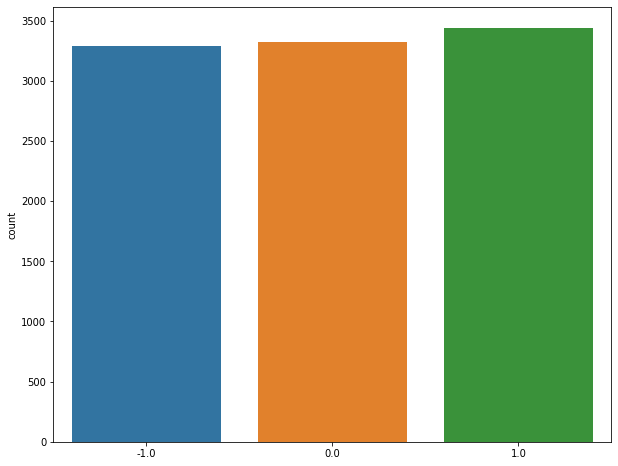

In [9]:
desired_response = np.array([])
for j in range(len(results)):
    desired_response = np.append(desired_response,results[j])
plt.figure(figsize=(10,8))
sns.countplot(x = desired_response)

## This shows that the data is very balanced

## Now we see the actual responses

<AxesSubplot:ylabel='count'>

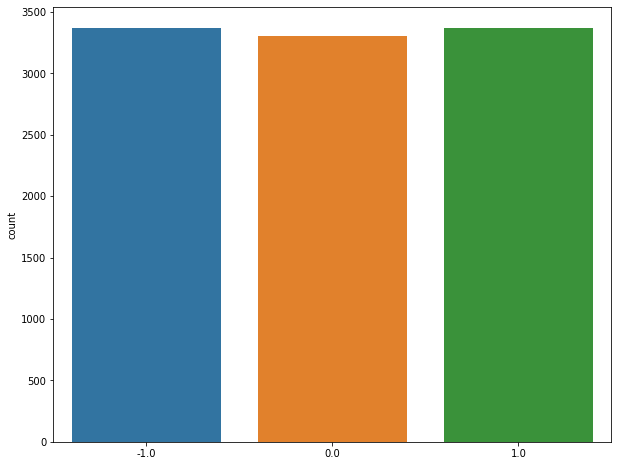

In [10]:
actual_response = np.array([])
for i in range(len(alldat)):
    actual_response = np.append(actual_response,alldat[i]['response'])
plt.figure(figsize=(10,8))
sns.countplot(x = actual_response)

## This shows that the actual response was very close to desired response

In [11]:
from sklearn.metrics import classification_report,confusion_matrix

In [12]:
confusion_matrix(desired_response,actual_response,labels=[-1,0,1])

array([[2383,  658,  247],
       [ 791, 1882,  648],
       [ 199,  765, 2477]], dtype=int64)

## This shows that a lot of times the mouse chose the undesired option

# Converting the brain area into brain regions

In [13]:
lis = []
for i in range(len(alldat)):
    for j in range(len(alldat[i]['brain_area'])):
        lis.append(alldat[i]['brain_area'][j])
df = pd.DataFrame(lis,columns=['dt'])       
br = df['dt'].unique().tolist()

## We need to make a table of data

In [14]:
# This creates a list of all experiments and Neurons
neurons_fired = []
for i in range(len(dat['spks'][0,:,0])):
    temp = [0]*len(br)
    neurons_fired.append(temp)
len(neurons_fired)

214

In [15]:
# Creates a dictionary with neurons as the keys and corresponding index as values
dictionary = {}
for i in range(len(br)):
    dictionary[br[i]] = i
# dictionary

## Defining a Threshold

In [16]:
threshold = 10 #int(input())

## Filling the data with the neurons spikes

In [17]:
for k in range(len(dat['spks'][0,:,0])):
    for l in range(len(dat['spks'][:,k,:])):
        if sum(dat['spks'][:,k,50:][l]) >= threshold:
            index = dictionary.get(dat['brain_area'][l])
            neurons_fired[k][index] = 1
# neurons_fired[8]

## Creating dataset for first response

In [18]:
activity = pd.DataFrame(data = neurons_fired,index = np.arange(len(dat['spks'][0])),columns=br)
activity['response_time'] = dat['response_time']
activity['gocue'] = dat['gocue']
activity['feedback_time'] = dat['feedback_time']
df = pd.DataFrame(dat['face'][0])
df.mean(axis=1)
pupil = df.mean(axis=1).tolist()
activity['pupil'] = pupil
activity['contrast_left'] = dat['contrast_left']
activity['contrast_right'] = dat['contrast_right']
activity['feedback_type'] = dat['feedback_type']
activity['prev_reward'] = dat['prev_reward']
# activity['results'] = results[0]
activity['response'] = dat['response']
activity['response'] = activity['response'].apply(lambda x : int(x))


## Here we concat all the responses

In [19]:
for m in range(1, len(alldat)):
    dat = alldat[m]
    i = 0
    j = 0
    neurons_fired = []
    for i in range(len(dat['spks'][0,:,0])):
        temp = [0]*len(br)
        neurons_fired.append(temp)
    for i in range(len(dat['spks'][0,:,0])):
        for j in range(len(dat['spks'][:,i,:])):
            if sum(dat['spks'][:,i,50:][j]) >= threshold:
                index = dictionary.get(dat['brain_area'][j])
                neurons_fired[i][index] = 1
    activity1 = pd.DataFrame(data = neurons_fired,index = np.arange(len(dat['spks'][0])),columns=br)
    activity1['response_time'] = dat['response_time']
    activity1['gocue'] = dat['gocue']
    activity1['feedback_time'] = dat['feedback_time']
    df = pd.DataFrame(dat['face'][0])
    df.mean(axis=1)
    pupil = df.mean(axis=1).tolist()
    activity1['pupil'] = pupil
    activity1['contrast_left'] = dat['contrast_left']
    activity1['contrast_right'] = dat['contrast_right']
    activity1['feedback_type'] = dat['feedback_type']
    activity1['prev_reward'] = dat['prev_reward']
#     activity1['results'] = results[m]
    activity1['response'] = dat['response']
    activity1['response'] = activity1['response'].apply(lambda x : int(x))
    
    activity = activity.append(activity1)
    activity.index = np.arange(len(activity))
    print(" Data " + str(m) +" is done!")
    

 Data 1 is done!
 Data 2 is done!
 Data 3 is done!
 Data 4 is done!
 Data 5 is done!
 Data 6 is done!
 Data 7 is done!
 Data 8 is done!
 Data 9 is done!
 Data 10 is done!
 Data 11 is done!
 Data 12 is done!
 Data 13 is done!
 Data 14 is done!
 Data 15 is done!
 Data 16 is done!
 Data 17 is done!
 Data 18 is done!
 Data 19 is done!
 Data 20 is done!
 Data 21 is done!
 Data 22 is done!
 Data 23 is done!
 Data 24 is done!
 Data 25 is done!
 Data 26 is done!
 Data 27 is done!
 Data 28 is done!
 Data 29 is done!
 Data 30 is done!
 Data 31 is done!
 Data 32 is done!
 Data 33 is done!
 Data 34 is done!
 Data 35 is done!
 Data 36 is done!
 Data 37 is done!
 Data 38 is done!


In [20]:
activity.to_csv('activity.csv')

# Loading DataSet

In [21]:
activity = pd.read_csv('activity.csv')
activity.drop('Unnamed: 0',axis = 1, inplace=True)
activity

,ACA,MOs,LS,root,VISp,CA3,SUB,DG,CA1,VISl,...,CA,response_time,gocue,feedback_time,pupil,contrast_left,contrast_right,feedback_type,prev_reward,response
0,1,1,1,1,1,1,1,1,0,0,...,0,1.150204,1.027216,1.186819,2.285959,1.0,0.00,1.0,-10.000000,1
1,1,1,1,1,1,1,1,1,0,0,...,0,1.399503,0.874414,1.437623,2.177634,0.0,0.50,1.0,-4.733091,-1
2,1,1,1,1,1,1,1,1,0,0,...,0,0.949291,0.825213,0.986016,2.042832,1.0,0.50,1.0,-3.400174,1
3,1,1,1,1,1,1,1,1,0,0,...,0,2.266802,0.761612,2.296436,1.566414,0.0,0.00,1.0,-4.183592,0
4,1,1,1,1,1,1,1,1,0,0,...,0,0.816776,0.662010,0.827613,2.445785,0.5,1.00,-1.0,-3.248887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,1,1,0,1,1,0,1,1,1,0,...,0,2.297503,0.794097,2.297503,0.506089,1.0,0.25,-1.0,-2.625872,0
10046,1,1,0,1,1,0,1,1,1,0,...,0,1.158803,0.524700,1.158803,0.704037,1.0,0.25,-1.0,-2.477572,-1
10047,1,1,0,1,1,0,1,1,1,0,...,0,2.003709,0.504257,2.003709,0.434715,1.0,0.25,-1.0,-2.871709,0
10048,1,1,0,1,1,0,1,1,1,0,...,0,2.076758,0.574262,2.076758,0.255824,1.0,0.25,-1.0,-2.695968,0


In [22]:
activity.describe()

,ACA,MOs,LS,root,VISp,CA3,SUB,DG,CA1,VISl,...,CA,response_time,gocue,feedback_time,pupil,contrast_left,contrast_right,feedback_type,prev_reward,response
count,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.00000,10050.000000,10050.000000,10050.000000,...,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000
mean,0.291443,0.393234,0.066070,0.772438,0.318706,0.270149,0.22597,0.393333,0.539602,0.106468,...,0.025672,1.422832,0.705904,1.449457,1.484416,0.344478,0.332537,0.377711,-2.805656,-0.000100
std,0.454450,0.488492,0.248416,0.419279,0.465998,0.444059,0.41824,0.488514,0.498454,0.308451,...,0.158162,0.661416,0.200472,0.656565,0.620375,0.396888,0.388877,0.925969,1.505969,0.819275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.479414,0.395066,0.494678,0.022137,0.000000,0.000000,-1.000000,-20.176290,-1.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.842289,0.550406,0.873802,0.990148,0.000000,0.000000,-1.000000,-3.077682,-1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.183334,0.676430,1.205223,1.619727,0.250000,0.250000,1.000000,-2.472239,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,...,0.000000,2.102538,0.804812,2.124845,1.977596,0.500000,0.500000,1.000000,-1.889474,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,2.713576,1.198819,2.738448,3.793644,1.000000,1.000000,1.000000,-1.201311,1.000000


In [23]:
activity.columns

Index(['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1', 'VISl',
       'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB', 'LGd', 'TH',
       'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD', 'SSp', 'LD', 'CP',
       'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB', 'SCm', 'SCsg', 'POL',
       'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD', 'LH', 'ZI', 'SCs', 'RN', 'MS',
       'RSP', 'PAG', 'BLA', 'VPM', 'SSs', 'RT', 'MEA', 'ACB', 'OT', 'SI',
       'SNr', 'APN', 'VAL', 'IC', 'CA2', 'SCig', 'DP', 'CL', 'EP', 'BMA',
       'COA', 'CA', 'response_time', 'gocue', 'feedback_time', 'pupil',
       'contrast_left', 'contrast_right', 'feedback_type', 'prev_reward',
       'response'],
      dtype='object')

## Logistic Regression

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

In [54]:
X = activity.drop('response',axis=1)
# X = activity[['response_time', 'gocue', 'feedback_time', 'pupil',
#        'contrast_left', 'contrast_right', 'feedback_type', 'prev_reward']]
# X = activity[['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1', 'VISl',
#        'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB', 'LGd', 'TH',
#        'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD', 'SSp', 'LD', 'CP',
#        'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB', 'SCm', 'SCsg', 'POL',
#        'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD', 'LH', 'ZI', 'SCs', 'RN', 'MS',
#        'RSP', 'PAG', 'BLA', 'VPM', 'SSs', 'RT', 'MEA', 'ACB', 'OT', 'SI',
#        'SNr', 'APN', 'VAL', 'IC', 'CA2', 'SCig', 'DP', 'CL', 'EP', 'BMA',
#        'COA', 'CA']]
y = activity['response']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
lis = list(y_test)

In [56]:
lor = LogisticRegression(max_iter=100000)

In [57]:
lor.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [58]:
preds = lor.predict(X_test)

In [59]:
print(confusion_matrix(preds,y_test))

[[724   0 138]
 [ 23 831  15]
 [ 88   0 694]]


In [60]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

          -1       0.87      0.84      0.85       862
           0       1.00      0.96      0.98       869
           1       0.82      0.89      0.85       782

    accuracy                           0.89      2513
   macro avg       0.90      0.89      0.89      2513
weighted avg       0.90      0.89      0.90      2513



## Scaling Data for Deep Learning with Keras



In [62]:
X = activity.drop('response',axis=1).values
# X = activity[['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1', 'VISl',
#        'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB', 'LGd', 'TH',
#        'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD', 'SSp', 'LD', 'CP',
#        'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB', 'SCm', 'SCsg', 'POL',
#        'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD', 'LH', 'ZI', 'SCs', 'RN', 'MS',
#        'RSP', 'PAG', 'BLA', 'VPM', 'SSs', 'RT', 'MEA', 'ACB', 'OT', 'SI',
#        'SNr', 'APN', 'VAL', 'IC', 'CA2', 'SCig', 'DP', 'CL', 'EP', 'BMA',
#        'COA', 'CA']].values
y = activity['response'].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [64]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train)

StandardScaler()

In [65]:
import tensorflow
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
y_train = tensorflow.keras.utils.to_categorical(y_train, 3)
y_test = tensorflow.keras.utils.to_categorical(y_test, 3)

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [67]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=50)

## Adding layers to the model

In [68]:
model = Sequential()
model.add(Dense(81,activation='gelu'))
model.add(Dropout(0.5))
model.add(Dense(40,activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(30,activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(22,activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(17,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

In [69]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [70]:
model.fit(x=X_train,y=y_train,epochs=600,validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/600
236/236 [==============================] - 4s 6ms/step - loss: 1.5515 - val_loss: 0.8426
Epoch 2/600
236/236 [==============================] - 1s 4ms/step - loss: 0.9918 - val_loss: 0.5856
Epoch 3/600
236/236 [==============================] - 1s 4ms/step - loss: 0.7202 - val_loss: 0.5796
Epoch 4/600
236/236 [==============================] - 1s 4ms/step - loss: 0.6415 - val_loss: 0.5703
Epoch 5/600
236/236 [==============================] - 1s 4ms/step - loss: 0.5998 - val_loss: 0.5668
Epoch 6/600
236/236 [==============================] - 1s 2ms/step - loss: 0.5908 - val_loss: 0.5529
Epoch 7/600
236/236 [==============================] - 1s 3ms/step - loss: 0.5840 - val_loss: 0.5505
Epoch 8/600
236/236 [==============================] - 1s 3ms/step - loss: 0.5636 - val_loss: 0.5413
Epoch 9/600
236/236 [==============================] - 1s 4ms/step - loss: 0.5600 - val_loss: 0.5388
Epoch 10/600
236/236 [==============================] - 1s 4ms/step - loss: 0.5541 - val_lo

236/236 [==============================] - 1s 4ms/step - loss: 0.1641 - val_loss: 0.1488
Epoch 82/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1606 - val_loss: 0.1410
Epoch 83/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1572 - val_loss: 0.1362
Epoch 84/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1524 - val_loss: 0.1414
Epoch 85/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1484 - val_loss: 0.1504
Epoch 86/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1529 - val_loss: 0.1322
Epoch 87/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1520 - val_loss: 0.1370
Epoch 88/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1507 - val_loss: 0.1380
Epoch 89/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1524 - val_loss: 0.1369
Epoch 90/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1534 - val_loss: 

Epoch 161/600
236/236 [==============================] - 1s 4ms/step - loss: 0.1295 - val_loss: 0.1369
Epoch 00161: early stopping


In [71]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

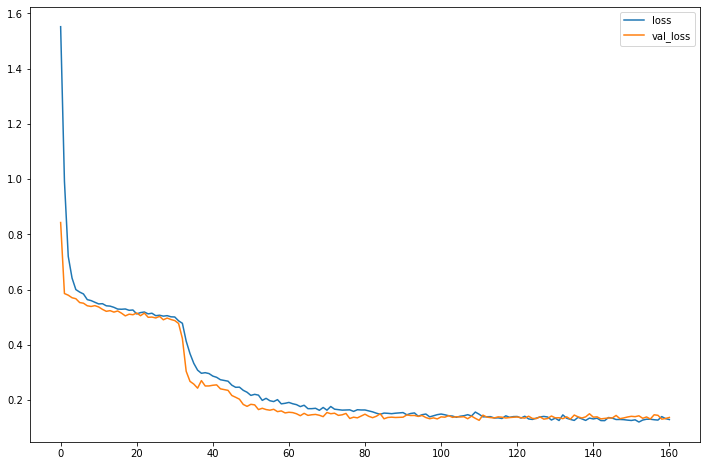

In [72]:
losses.plot(figsize=(12,8))

## Predicting the model

In [73]:
pred = (model.predict(X_test) > 0.5).astype("int32")

## Scaling the data to be 1-D array

In [74]:
predictions = []
for i in range(len(pred)):
        if pred[i][0] == 1 :
            predictions.append(-1)
        elif pred[i][1] == 1 :
            predictions.append(0)
        else:
            predictions.append(1)

In [75]:
y_tests = []
for i in range(len(y_test)):
        if int(y_test[i][0]) == 1 :
            y_tests.append(-1)
        elif int(y_test[i][1]) == 1 :
            y_tests.append(0)
        else:
            y_tests.append(1)

In [76]:
confusion_matrix(predictions,y_tests)

array([[830,   5,   4],
       [  0, 761,  75],
       [  1,  81, 756]], dtype=int64)

In [77]:
print(classification_report(predictions,y_tests))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       839
           0       0.90      0.91      0.90       836
           1       0.91      0.90      0.90       838

    accuracy                           0.93      2513
   macro avg       0.93      0.93      0.93      2513
weighted avg       0.93      0.93      0.93      2513



## Comparing Logistic Regression and Keras model

In [78]:
# print(classification_report(preds,lis))

In [79]:
print(classification_report(predictions,y_tests))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       839
           0       0.90      0.91      0.90       836
           1       0.91      0.90      0.90       838

    accuracy                           0.93      2513
   macro avg       0.93      0.93      0.93      2513
weighted avg       0.93      0.93      0.93      2513



# Thank You

## Visualizing data

In [80]:
activity

,ACA,MOs,LS,root,VISp,CA3,SUB,DG,CA1,VISl,...,CA,response_time,gocue,feedback_time,pupil,contrast_left,contrast_right,feedback_type,prev_reward,response
0,1,1,1,1,1,1,1,1,0,0,...,0,1.150204,1.027216,1.186819,2.285959,1.0,0.00,1.0,-10.000000,1
1,1,1,1,1,1,1,1,1,0,0,...,0,1.399503,0.874414,1.437623,2.177634,0.0,0.50,1.0,-4.733091,-1
2,1,1,1,1,1,1,1,1,0,0,...,0,0.949291,0.825213,0.986016,2.042832,1.0,0.50,1.0,-3.400174,1
3,1,1,1,1,1,1,1,1,0,0,...,0,2.266802,0.761612,2.296436,1.566414,0.0,0.00,1.0,-4.183592,0
4,1,1,1,1,1,1,1,1,0,0,...,0,0.816776,0.662010,0.827613,2.445785,0.5,1.00,-1.0,-3.248887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,1,1,0,1,1,0,1,1,1,0,...,0,2.297503,0.794097,2.297503,0.506089,1.0,0.25,-1.0,-2.625872,0
10046,1,1,0,1,1,0,1,1,1,0,...,0,1.158803,0.524700,1.158803,0.704037,1.0,0.25,-1.0,-2.477572,-1
10047,1,1,0,1,1,0,1,1,1,0,...,0,2.003709,0.504257,2.003709,0.434715,1.0,0.25,-1.0,-2.871709,0
10048,1,1,0,1,1,0,1,1,1,0,...,0,2.076758,0.574262,2.076758,0.255824,1.0,0.25,-1.0,-2.695968,0


In [84]:
activity.corr()

,ACA,MOs,LS,root,VISp,CA3,SUB,DG,CA1,VISl,...,CA,response_time,gocue,feedback_time,pupil,contrast_left,contrast_right,feedback_type,prev_reward,response
ACA,1.000000,0.562221,0.412957,-0.188260,0.265734,-0.284661,0.366037,0.432971,0.180777,-0.221382,...,-0.104103,-0.022273,-0.041021,-0.021218,-0.016514,-0.059435,-0.018161,0.011513,-0.094205,-0.015157
MOs,0.562221,1.000000,0.199184,-0.237916,0.297034,-0.168193,0.177278,0.152018,-0.048841,-0.277887,...,0.079271,-0.039880,-0.042517,-0.039663,0.026173,-0.012255,0.009462,0.020963,-0.029638,-0.000151
LS,0.412957,0.199184,1.000000,-0.168057,0.002045,0.031232,0.194390,0.330323,0.072092,-0.091812,...,-0.043174,-0.008558,-0.046158,-0.007942,-0.015986,-0.005787,0.021061,-0.003807,-0.073937,0.002477
root,-0.188260,-0.237916,-0.168057,1.000000,-0.200222,0.047479,0.031094,0.069259,0.019079,0.173508,...,0.088103,-0.028311,0.013416,-0.028258,0.021384,0.010208,0.013435,0.018667,0.013282,-0.000066
VISp,0.265734,0.297034,0.002045,-0.200222,1.000000,-0.192978,0.436150,0.435891,0.246193,0.073375,...,-0.111020,0.031029,0.171045,0.031061,-0.016648,-0.024138,-0.005144,-0.016791,0.000739,-0.004869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
contrast_left,-0.059435,-0.012255,-0.005787,0.010208,-0.024138,0.021452,-0.004082,-0.014227,-0.001057,0.027970,...,0.022392,-0.233436,0.021668,-0.235063,0.207073,1.000000,-0.065721,-0.000308,0.006692,0.496198
contrast_right,-0.018161,0.009462,0.021061,0.013435,-0.005144,-0.002500,-0.001035,-0.013761,-0.029057,-0.039253,...,0.005591,-0.261888,-0.010745,-0.263285,0.221353,-0.065721,1.000000,0.002677,-0.004121,-0.418752
feedback_type,0.011513,0.020963,-0.003807,0.018667,-0.016791,0.017791,-0.041828,-0.042699,-0.040820,-0.032107,...,0.013964,-0.281714,-0.046004,-0.260628,0.329767,-0.000308,0.002677,1.000000,-0.014168,0.031400
prev_reward,-0.094205,-0.029638,-0.073937,0.013282,0.000739,0.054442,0.036887,-0.013237,0.017469,0.050800,...,-0.051658,-0.041849,-0.016468,-0.042600,-0.010356,0.006692,-0.004121,-0.014168,1.000000,-0.000298


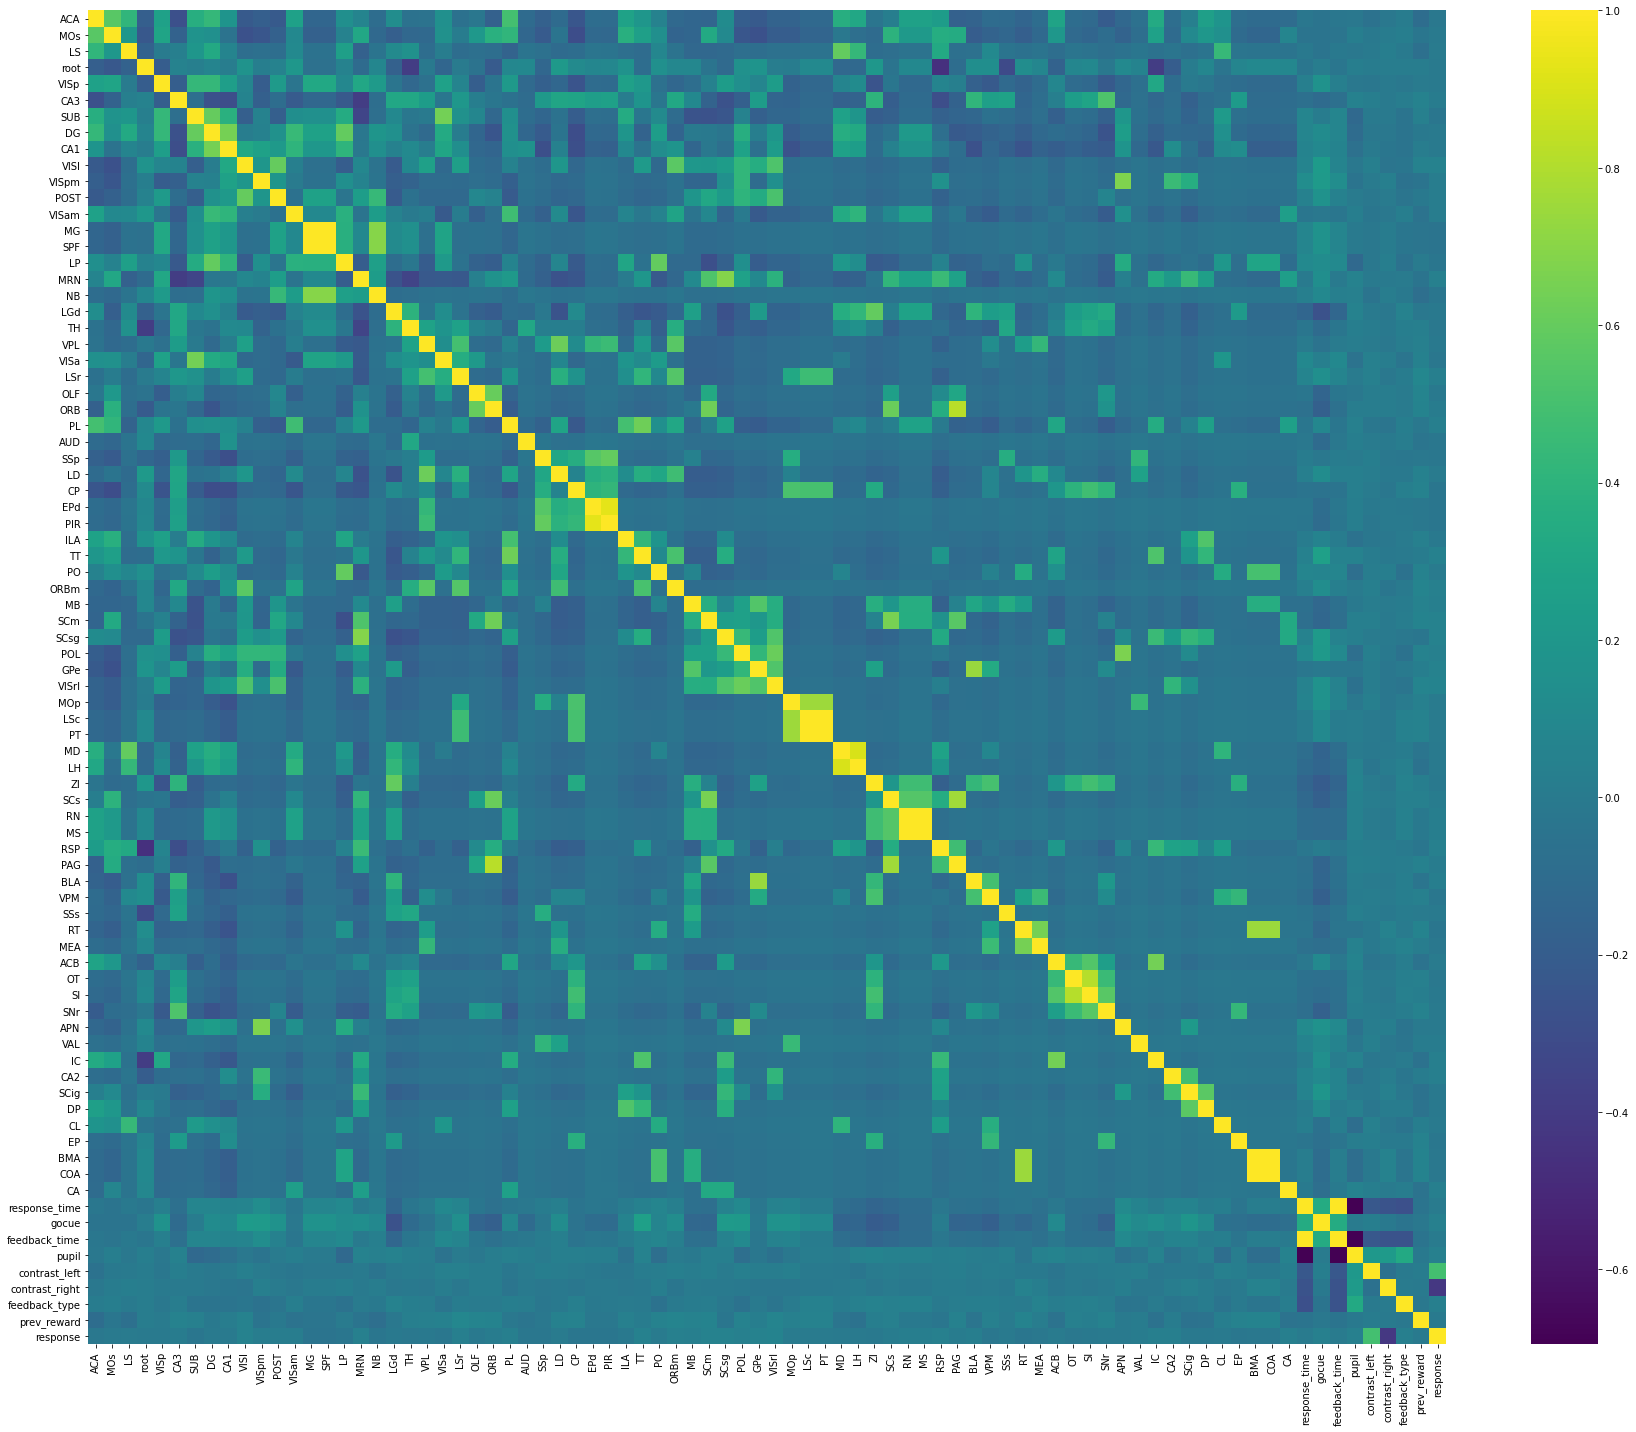

In [81]:
plt.figure(figsize=(25,20))
sns.heatmap(activity.corr(),cmap='viridis')
plt.tight_layout()

<Figure size 1800x1440 with 0 Axes>

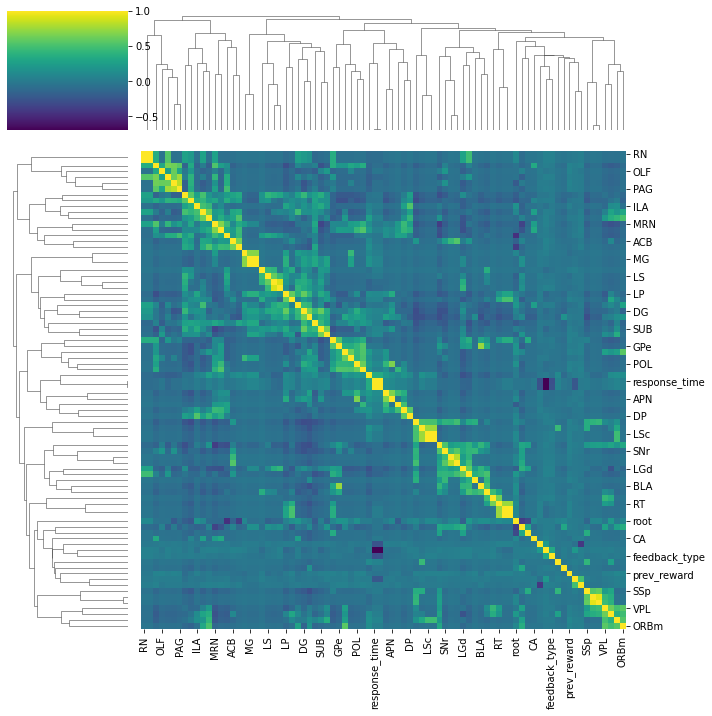

In [82]:
plt.figure(figsize=(25,20))
sns.clustermap(activity.corr(),cmap='viridis')
plt.tight_layout()

<AxesSubplot:>

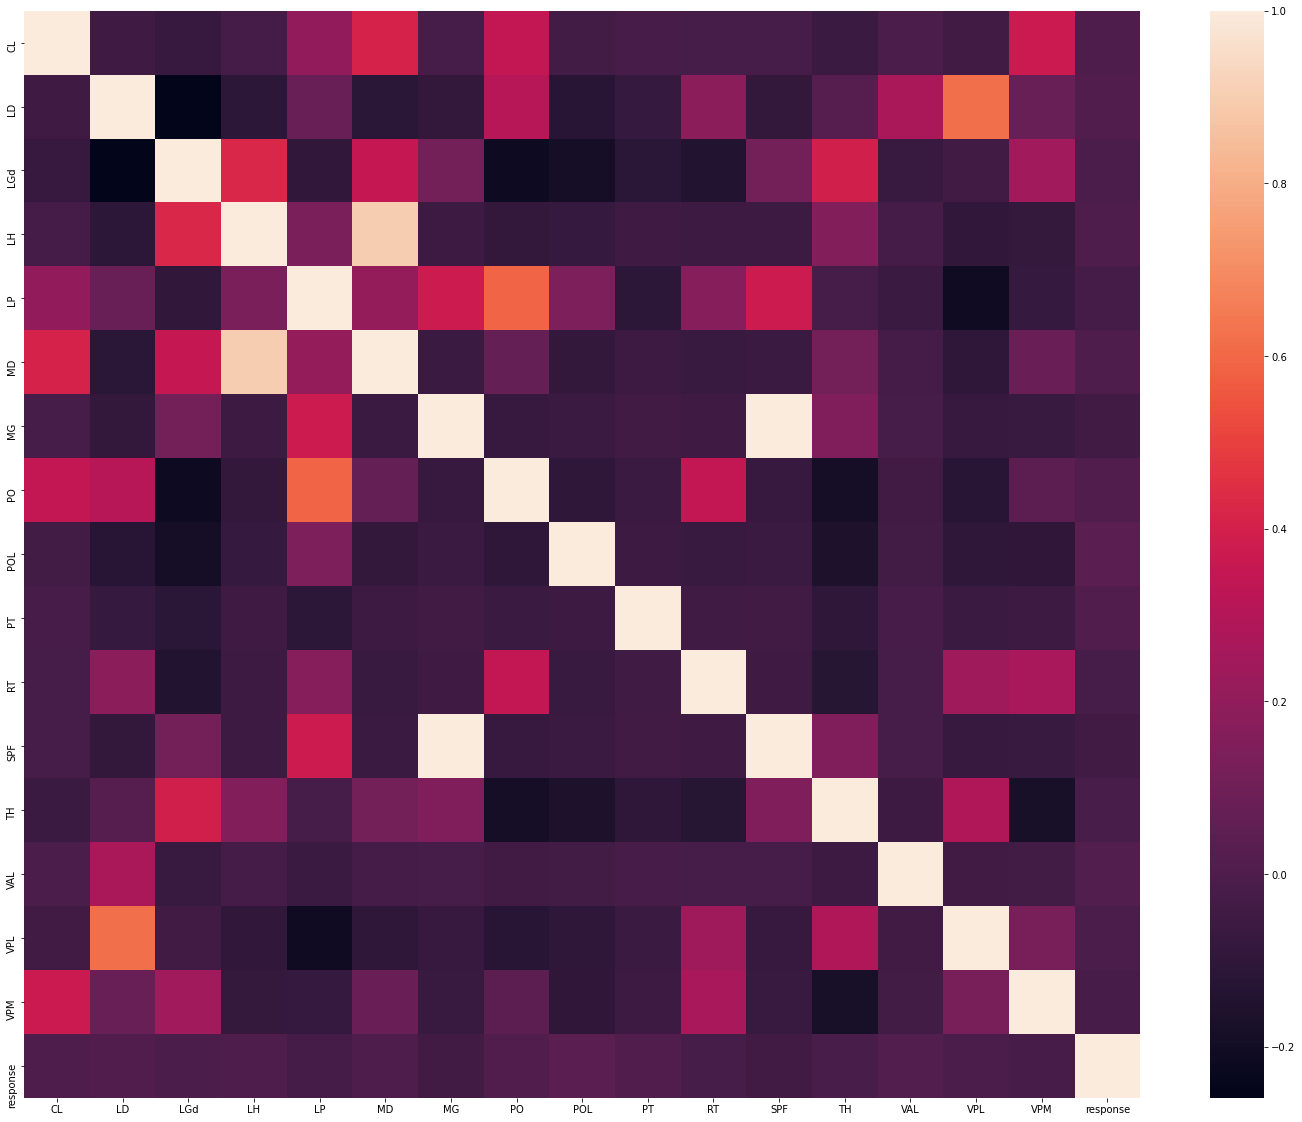

In [83]:
plt.figure(figsize=(25,20))
sns.heatmap(activity[["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM","response"]].corr())

### It is evident that the model is very accurate in its predictions, but there is a problem here.

This model relies more on outer data like gocue sound, contrast ratio, etc. This deviates us from making actual predictions using just the neurons.

Hence, we now visualize the data in a more neuron focused way.